In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from scipy.integrate import quad

In [3]:
from scipy.optimize import curve_fit

In [4]:
def τ(w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    return np.log((x * (1-y)) / ((1-x) * y)) / np.log(w_j / w_i)


def T(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0, PLOT_N=False, PLOT_δ=False ):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - 2*((w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - 2*((w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - 2*((w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - 2*((w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here...
    

    
    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # 
    τ_euwt_eumt = τ(w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals  # why delta*N and not 2*s*delta*N
    τ_euwt_anwt = τ(w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # 
    τ_anwt_anmt = τ(w_anwt, w_anmt, x=1-1/N, y=np.maximum(μ2,1/N))
     # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ(w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        1/p_min 
        + 1/p_anwt_anmt 
        + 1/p_anmt_eumt 
        + τ_euwt_anwt  
#        + τ_anwt_anmt  # no fix of anmt, don't count
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    
    if PLOT_N:
        plt.plot(N, 1/p_min, label='T_min', color='blue')
        plt.plot(N, 1/p_anwt_anmt, label='T_anwt_anmt', color='orange' )
        plt.plot(N, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(N, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(N, τ_anwt_anmt, '--', label='τ_anwt_anmt', color='red')
        plt.plot(N, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
        
    if PLOT_δ:
        plt.plot(δ, 1/p_min, label='T_min', color='blue')
        plt.plot(δ, [1/p_anwt_anmt for d in δ], label='T_anwt_anmt', color='orange' )
        plt.plot(δ, 1/p_anmt_eumt, label='T_anmt_eumt', color='red' )
        plt.plot(δ, τ_euwt_anwt, '--', label='τ_euwt_anwt', color='orange')
        plt.plot(δ, [τ_anwt_anmt for d in δ], '--', label='τ_anwt_anmt', color='red')
        plt.plot(δ, τ_anmt_eumt, '--', label='τ_anmt_eumt', color='purple')
        plt.legend()
#         plt.yscale('log')
        plt.xscale('log')
        plt.ylim(0, None)
    return T

In [5]:
((1.028-1.025)/1.025)**2, ((1.028-1.021)/1.021)**2, ((1.028-1)/1)**2, ((1.021-1)/1)**2

(8.566329565735332e-06,
 4.700505831984894e-05,
 0.0007840000000000014,
 0.00044099999999999614)

In [6]:
import mpmath as mp

def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0] #  limit=100

def mpintegral(f, N, s, a, b):
    f = partial(f, N, s)    
    return mp.quad(f, [a, b], verbose=False)

def I1(N, s, x):
    if x == 1:
        return 0
    S = 2*N*s
#     return np.expm1(S*x) * (np.exp(-S*x) - np.exp(-S)) / (x * (1-x)) # first term overflow so I rearranged:
    return (np.exp(-S) - np.exp(-S*x) - np.expm1(-S*(1-x))) / (x * (1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    S = 2*N*s
    # use mp instad of np for high precision due to expm1(S*x)
    return -mp.expm1(S*x) * mp.expm1(-S*x) / (x * (1-x)) 

def p_kimura(N, s, x0=None):
    if x0 is None: x0 = 1 / N
    S = 2 * N * s
    numer = np.expm1(-S * x0)
    denom = np.expm1(-S)
    return numer / denom

@np.vectorize
def τ_kimura(N, w_i, w_j, x, y):
    """j invades i, starting at freq y and reaching freq x
    """
    s = (w_j - w_i) / w_i    
    x0, max_x, min_x = y, x, 0
    S = 2 * N * s
    J1 = -1.0 / (s * np.expm1(-S)) * integral(I1, N, s, x0, max_x)
    u = p_kimura(N, s, x0)
    # use mpintegral with mp.quad for high precision due to expm1(S*x) in I2
    J2 = -1.0 / (s * np.expm1(-S)) * mpintegral(I2, N, s, min_x, x0)
#     print(J1, J2, u, 1-u)
    return J1 + ((1 - u) / u) * J2 # eq 17 in Kimura & Ohta, Genetics 1969


In [7]:
def T_kimura(N, μ1, μ2, δ, w_euwt, w_anwt, w_anmt, w_eumt, x_0=0):
    assert w_euwt < w_anwt < w_anmt < w_eumt
    p_euwt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_euwt) / w_euwt) * μ1)**N
    p_euwt_anwt = 1 - (1 - p_kimura(N, (w_anwt - w_euwt) / w_euwt) * δ)**N
    p_anwt_anmt = 1 - (1 - p_kimura(N, (w_anmt - w_anwt) / w_anwt) * μ2)**N
    # no fix of anmt - use w_anwt; 
#     p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N # N doesnt make sense here but it doesnt seem to matter
    
    δ=np.array([δ])
    if δ.all() == 0:
        p_anmt_eumt = 1
    else: p_anmt_eumt = 1 - (1 - p_kimura(N, (w_eumt - w_anwt) / w_anwt) * δ)**N  # N doesnt make sense here...
    

    p_min = 1 - (1 - p_euwt_eumt) * (1 - p_euwt_anwt)
    p_a = p_euwt_anwt / (p_euwt_eumt + p_euwt_anwt)
    
    # τ_kimura(N, s, x0=None, max_x=1, min_x=0)
    τ_euwt_eumt = τ_kimura(N, w_euwt, w_eumt, x=0.95, y=np.maximum(x_0,1/N))
    # start with one or delta*N individuals
    τ_euwt_anwt = τ_kimura(N, w_euwt, w_anwt, x=1-1/N, y=np.maximum(δ, 1/N)) 
    # no fix of anmt, don't count
    # τ_anwt_anmt = τ_kimura(N, w_anwt, w_anmt, x=1-1/N, y=1/N)
    # no fix of anmt - use w_anwt; # start with one or delta*N individuals
    τ_anmt_eumt = τ_kimura(N, w_anwt, w_eumt, x=0.95, y=np.maximum(δ, 1/N))
    
    T_m = 1/p_min + τ_euwt_eumt
    T_a = (
        # euwt->anwt
        1/p_min 
        + τ_euwt_anwt 
        # anwt->anmt
        + 1/p_anwt_anmt 
#         + τ_anwt_anmt  # no fix of anmt, don't count
        # anmt->eumt
        + 1/p_anmt_eumt
        + τ_anmt_eumt 
    )             
    T =  p_a * T_a + (1 - p_a) * T_m
    return T

# No aneuploidy

## Population size

In [8]:
Nm58, msim_noaneuN_manu58=np.load('msim_noaneuN_manu58.npy',allow_pickle=True)
Nm58 = Nm58.astype('float64')

msim_noaneuN58=np.array([x for x in msim_noaneuN_manu58[0]])

In [9]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 0, 1, 1.021, 1.025, 1.028

In [10]:
T__ = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #,x_0=35*μ)

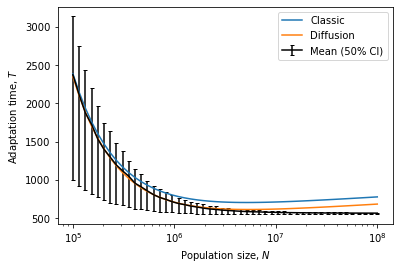

In [11]:
mean = msim_noaneuN58.mean(axis=1)
low = np.percentile(msim_noaneuN58, 25, axis=1)
high = np.percentile(msim_noaneuN58, 75, axis=1)
plt.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(N, T__, label='Classic')
plt.plot(N, T_, label='Diffusion')


plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e7,1e8])
#plt.ylim([500,700])
plt.xlabel("Population size, $N$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [12]:
35*μ*N

array([  0.336     ,   0.38686704,   0.44543856,   0.51287376,
         0.59052336,   0.67992288,   0.7828632 ,   0.90138384,
         1.03785024,   1.19497728,   1.37588976,   1.58419296,
         1.82403312,   2.1001848 ,   2.4181416 ,   2.78423712,
         3.2057592 ,   3.69109776,   4.2499128 ,   4.89332928,
         5.63415552,   6.48714192,   7.46926656,   8.60007792,
         9.90209136,  11.40122256,  13.12731504,  15.11473152,
        17.40303264,  20.03777328,  23.07139968,  26.56430448,
        30.58601616,  35.21660016,  40.54823136,  46.68704544,
        53.75525232,  61.89354864,  71.26394688,  82.0529808 ,
        94.47542496, 108.778572  , 125.24714832, 144.20898912,
       166.04156688, 191.1794976 , 220.1231928 , 253.448832  ,
       291.81982032, 336.        ])

## Mutation rate

In [13]:
μm, msim_noaneuμ_manu=np.load('msim_noaneuμ_manu.npy',allow_pickle=True)
μm = μm.astype('float64')

msim_noaneuμ_manu=np.array([x for x in msim_noaneuμ_manu[0]])

In [14]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm, 0, 1, 1.021,1.025, 1.028

In [15]:
T__ = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)

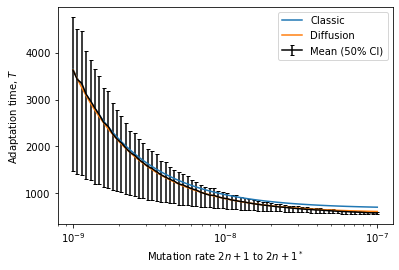

In [16]:
mean = np.mean(msim_noaneuμ_manu, axis=1)
low = np.percentile(msim_noaneuμ_manu, 25, axis=1)
high = np.percentile(msim_noaneuμ_manu, 75, axis=1)
plt.errorbar(μ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(μ, T__, label='Classic')
plt.plot(μ, T_, label='Diffusion')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e-8,1e-7])
#plt.ylim([530,1000])
plt.xlabel("Mutation rate $2n+1$ to $2n+1^*$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

In [17]:
37*μ*N

array([ 0.222     ,  0.23732226,  0.25370206,  0.27121237,  0.28993123,
        0.30994206,  0.33133401,  0.35420242,  0.37864919,  0.40478326,
        0.43272107,  0.46258714,  0.49451454,  0.52864554,  0.56513223,
        0.60413721,  0.64583428,  0.69040924,  0.73806074,  0.78900111,
        0.84345734,  0.90167209,  0.96390478,  1.03043272,  1.10155237,
        1.17758064,  1.25885631,  1.34574158,  1.43862359,  1.53791625,
        1.644062  ,  1.75753385,  1.87883744,  2.00851331,  2.1471393 ,
        2.29533315,  2.45375521,  2.62311145,  2.80415651,  2.99769716,
        3.20459584,  3.42577449,  3.66221872,  3.91498215,  4.1851911 ,
        4.47404966,  4.78284501,  5.11295317,  5.46584513,  5.84309341,
        6.24637907,  6.67749919,  7.13837487,  7.63105983,  8.15774951,
        8.72079089,  9.32269294,  9.96613779, 10.6539927 , 11.3893228 ,
       12.1754048 , 13.01574155, 13.91407768, 14.87441626, 15.90103664,
       16.99851354, 18.17173742, 19.42593628, 20.76669896, 22.2 

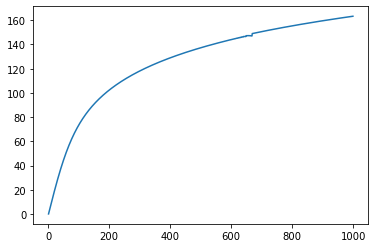

In [18]:
n=np.arange(1,1000)
plt.plot(n,τ_kimura(1e8, w_euwt, w_eumt, x=0.95, y=1/1e8)-τ_kimura(1e8, w_euwt, w_eumt, x=0.95, y=n/1e8))

In [19]:
τ_kimura(1e8, w_euwt, w_eumt, x=0.95, y=1/1e8)

array(mpf('679.71188716338872'), dtype=object)

## Shifted x axis

In [27]:
μm68, msim_noaneuμ68_manu=np.load('msim_noaneuμ68_manu.npy',allow_pickle=True)
μm68= μm68.astype('float64')

msim_noaneuμ68_manu=np.array([x for x in msim_noaneuμ68_manu[0]])

In [28]:
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm68, 0, 1, 1.021,1.025, 1.028

In [29]:
T__ = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)

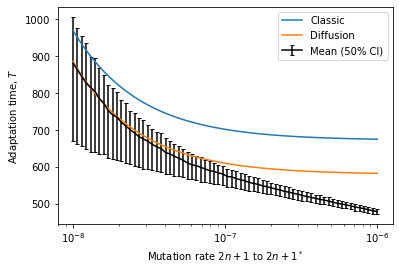

In [31]:
mean = np.mean(msim_noaneuμ68_manu, axis=1)
low = np.percentile(msim_noaneuμ68_manu, 25, axis=1)
high = np.percentile(msim_noaneuμ68_manu, 75, axis=1)
plt.errorbar(μ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')

plt.plot(μ, T__, label='Classic')
plt.plot(μ, T_, label='Diffusion')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim([1e-8,1e-7])
#plt.ylim([530,1000])
plt.xlabel("Mutation rate $2n+1$ to $2n+1^*$")
plt.ylabel('Adaptation time, $T$')
plt.legend();

## Gridplots

''

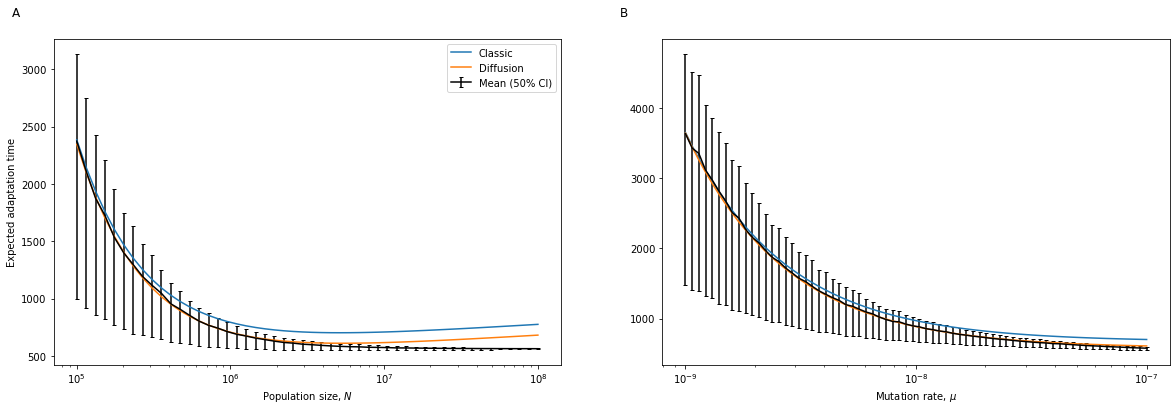

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6)#, sharey=True
                              )
N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = Nm58, 9.6e-08, 0, 1, 1.021, 1.025, 1.028
T__ = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt)
T_ = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt)
mean = msim_noaneuN58.mean(axis=1)
low = np.percentile(msim_noaneuN58, 25, axis=1)
high = np.percentile(msim_noaneuN58, 75, axis=1)
ax1.set_title('A',x=-.075,y=1.05)

ax1.set_ylabel('Expected adaptation time')

ax1.errorbar(N, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')
ax1.plot(N, T__, label='Classic')
ax1.plot(N, T_, label='Diffusion')

ax1.set_xlabel('Population size, $N$')
ax1.set_xscale('log')
ax1.legend()




N, μ, δ, w_euwt, w_anwt, w_anmt, w_eumt = 6e6, μm, 0, 1, 1.021,1.025, 1.028
T__ = T(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
T_ = T_kimura(N, μ, μ, 0, w_euwt, w_anwt, w_anmt, w_eumt) #, x_0=35*μ)
mean = np.mean(msim_noaneuμ_manu, axis=1)
low = np.percentile(msim_noaneuμ_manu, 25, axis=1)
high = np.percentile(msim_noaneuμ_manu, 75, axis=1)

ax2.set_title('B',x=-.075,y=1.05)

ax2.errorbar(μ, mean, [mean-low, high-mean], color='k', capsize=2, label='Mean (50% CI)')
ax2.plot(μ, T__, label='Classic')
ax2.plot(μ, T_, label='Diffusion')
ax2.set_xlabel('Mutation rate, $μ$')
#ax2.set_ylim([500,4000])
ax2.set_xscale('log')
#ax2.legend()

#fig.savefig('figgrid_noaneu.pdf')
;